### Import

In [22]:
import xml.etree.ElementTree as ET
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

### Read Data

In [23]:
xml_file = "O-A0038-003.xml"
tree = ET.parse(xml_file)
root = tree.getroot()
ns = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}

lon0 = float(root.find('.//cwa:BottomLeftLongitude', ns).text)
lat0 = float(root.find('.//cwa:BottomLeftLatitude', ns).text)

content_text = root.find('.//cwa:Content', ns).text.strip()
values = [float(v) for v in content_text.replace('\n', ',').split(',') if v.strip()]

cols, rows = 67, 120
grid = np.array(values).reshape(rows, cols)

#有效=1, 無效=0
label_grid = np.where(grid == -999.0, 0, 1)
value_grid = np.where(grid == -999.0, np.nan, grid)

lon = np.linspace(lon0, lon0 + (cols - 1) * 0.03, cols)
lat = np.linspace(lat0, lat0 + (rows - 1) * 0.03, rows)

### Drawing Data

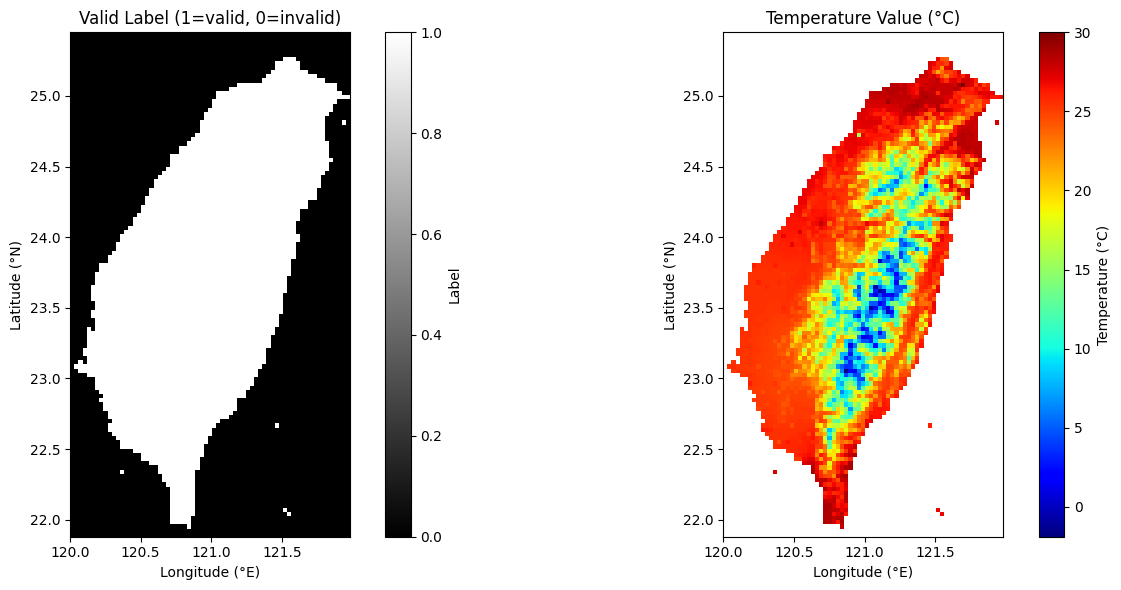

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im1 = axes[0].imshow(label_grid, extent=[lon.min(), lon.max(),
                                        lat.min(), lat.max()],
                     origin='lower', cmap='gray')
axes[0].set_title("Valid Label (1=valid, 0=invalid)")
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Latitude (°N)")
fig.colorbar(im1, ax=axes[0], label="Label")

im2 = axes[1].imshow(value_grid, extent=[lon.min(), lon.max(),
                                        lat.min(), lat.max()],
                     origin='lower', cmap='jet')
axes[1].set_title("Temperature Value (°C)")
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Latitude (°N)")
fig.colorbar(im2, ax=axes[1], label="Temperature (°C)")

plt.tight_layout()
plt.show()


### Make Dataset

In [25]:
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
lon_flat = lon_mesh.flatten()
lat_flat = lat_mesh.flatten()

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()

def norm_coords(lon_vals, lat_vals):
    lon_n = (lon_vals - lon_min) / (lon_max - lon_min)
    lat_n = (lat_vals - lat_min) / (lat_max - lat_min)
    return lon_n, lat_n

lon_norm, lat_norm = norm_coords(lon_flat, lat_flat)

In [26]:
class_tensor = torch.tensor(
    np.column_stack([lon_norm, lat_norm, label_grid.flatten()]),
    dtype=torch.float32
)

mask_valid = ~np.isnan(value_grid.flatten())
lon_norm_valid, lat_norm_valid = norm_coords(lon_flat[mask_valid], lat_flat[mask_valid])
reg_tensor = torch.tensor(
    np.column_stack([lon_norm_valid, lat_norm_valid,
                     value_grid.flatten()[mask_valid]]),
    dtype=torch.float32
)

In [27]:
def make_dataset(tensor, batch_size=64, split=0.8, target_index=-1):
    X = tensor[:, :2]
    y = tensor[:, target_index].unsqueeze(1)
    dataset = TensorDataset(X, y)
    n_train = int(len(dataset) * split)
    n_val = len(dataset) - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val])
    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True),
            DataLoader(val_ds, batch_size=batch_size))

class_train_loader, class_val_loader = make_dataset(class_tensor)
reg_train_loader,  reg_val_loader   = make_dataset(reg_tensor)

### Model setting

In [28]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 8), nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return torch.sigmoid(self.net(x))

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 32), nn.Tanh(),
            nn.Linear(32, 8), nn.Tanh(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

cls_model = Classifier()
reg_model = Regressor()

### Training

In [29]:
def train_classification_model(model, train_loader, val_loader, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        t_loss = 0
        for X, y in train_loader:
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
        train_losses.append(t_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            v_loss = sum(criterion(model(Xv), yv).item() for Xv, yv in val_loader) / len(val_loader)
        val_losses.append(v_loss)

        if epoch % 100 == 0:
            print(f"[Epoch {epoch:03d}] "
                  f"Cls Train={train_losses[-1]:.4f} | Cls Val={v_loss:.4f}")

    return train_losses, val_losses

cls_train_losses, cls_val_losses = train_classification_model(
    cls_model, class_train_loader, class_val_loader, epochs=1000
)

[Epoch 100] Cls Train=0.0575 | Cls Val=0.0533
[Epoch 200] Cls Train=0.0563 | Cls Val=0.0661
[Epoch 300] Cls Train=0.0462 | Cls Val=0.0611
[Epoch 400] Cls Train=0.0394 | Cls Val=0.0489
[Epoch 500] Cls Train=0.0385 | Cls Val=0.0369
[Epoch 600] Cls Train=0.0346 | Cls Val=0.0454
[Epoch 700] Cls Train=0.0325 | Cls Val=0.0565
[Epoch 800] Cls Train=0.0289 | Cls Val=0.0299
[Epoch 900] Cls Train=0.0281 | Cls Val=0.0387
[Epoch 1000] Cls Train=0.0293 | Cls Val=0.0364


In [30]:
def train_regression_model(model, train_loader, val_loader, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        t_loss = 0
        for X, y in train_loader:
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
        train_losses.append(t_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            v_loss = sum(criterion(model(Xv), yv).item() for Xv, yv in val_loader) / len(val_loader)
        val_losses.append(v_loss)

        if epoch % 100 == 0:
            print(f"[Epoch {epoch:03d}] "
                  f"Reg Train={train_losses[-1]:.4f} | Reg Val={v_loss:.4f}")

    return train_losses, val_losses

reg_train_losses, reg_val_losses = train_regression_model(
    reg_model, reg_train_loader, reg_val_loader, epochs=1000
)


[Epoch 100] Reg Train=37.8016 | Reg Val=38.1880
[Epoch 200] Reg Train=37.5484 | Reg Val=38.1745
[Epoch 300] Reg Train=37.7429 | Reg Val=38.1742
[Epoch 400] Reg Train=7.9609 | Reg Val=9.1383
[Epoch 500] Reg Train=7.3498 | Reg Val=8.9008
[Epoch 600] Reg Train=6.8996 | Reg Val=8.0714
[Epoch 700] Reg Train=6.6385 | Reg Val=7.7711
[Epoch 800] Reg Train=6.5099 | Reg Val=7.8035
[Epoch 900] Reg Train=6.3762 | Reg Val=7.6460
[Epoch 1000] Reg Train=6.1991 | Reg Val=7.5901


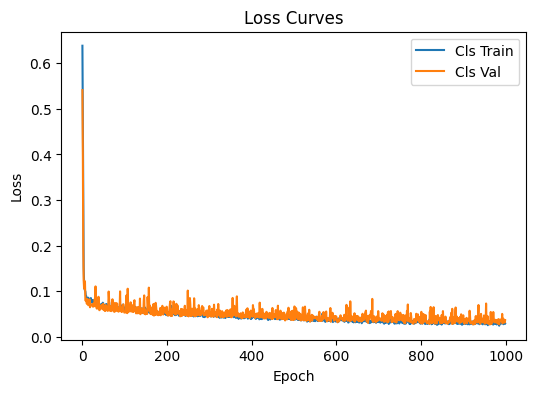

In [31]:
plt.figure(figsize=(6,4))
plt.plot(cls_train_losses, label='Cls Train')
plt.plot(cls_val_losses, label='Cls Val')

plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves")
plt.legend(); plt.show()


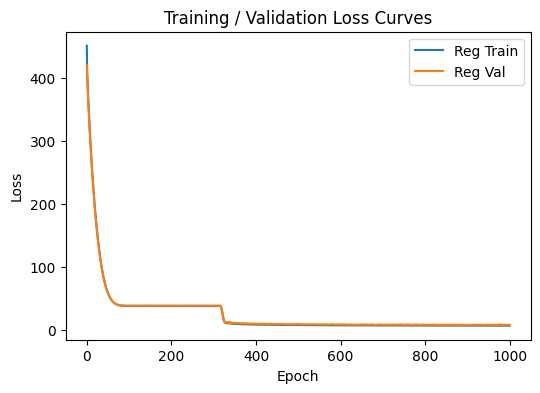

In [32]:
plt.figure(figsize=(6,4))
plt.plot(reg_train_losses, label='Reg Train')
plt.plot(reg_val_losses, label='Reg Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss Curves")
plt.legend()
plt.show()

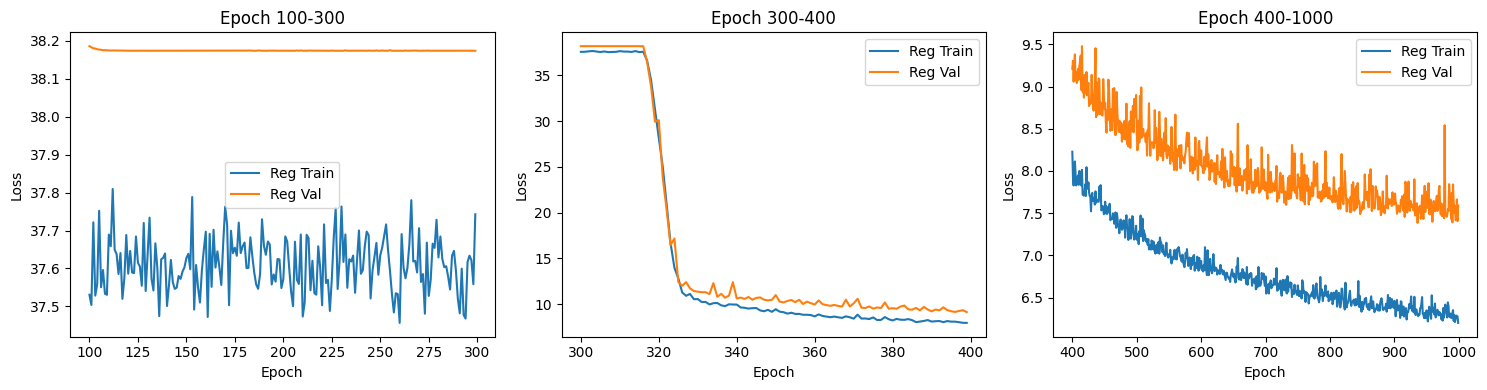

In [33]:
ranges = [(100,300), (300,400), (400,1000)]
epochs = list(range(len(reg_train_losses)))

plt.figure(figsize=(15,4))

for i, (start, end) in enumerate(ranges):
    plt.subplot(1, 3, i+1)
    plt.plot(epochs[start:end], reg_train_losses[start:end], label="Reg Train")
    plt.plot(epochs[start:end], reg_val_losses[start:end], label="Reg Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Epoch {start}-{end}")
    plt.legend()

plt.tight_layout()
plt.show()

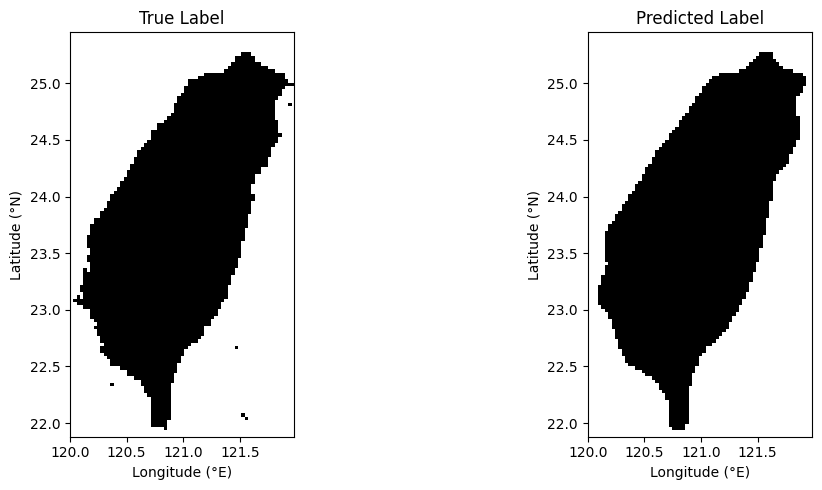

In [34]:
lon_grid, lat_grid = np.meshgrid(lon, lat)
lon_norm_g, lat_norm_g = norm_coords(lon_grid.flatten(), lat_grid.flatten())
test_points = torch.tensor(np.column_stack([lon_norm_g, lat_norm_g]),
                           dtype=torch.float32)

with torch.no_grad():
    pred_label = (cls_model(test_points) > 0.5).float().reshape(rows, cols)
    pred_value = reg_model(test_points).reshape(rows, cols)
    
mask = label_grid.astype(bool)
pred_masked = np.where(mask, pred_value.numpy(), np.nan)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(label_grid, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               origin='lower', cmap='binary')
axes[0].set_title("True Label")
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Latitude (°N)")

axes[1].imshow(pred_label, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               origin='lower', cmap='binary')
axes[1].set_title("Predicted Label")
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Latitude (°N)")

plt.tight_layout()
plt.show()

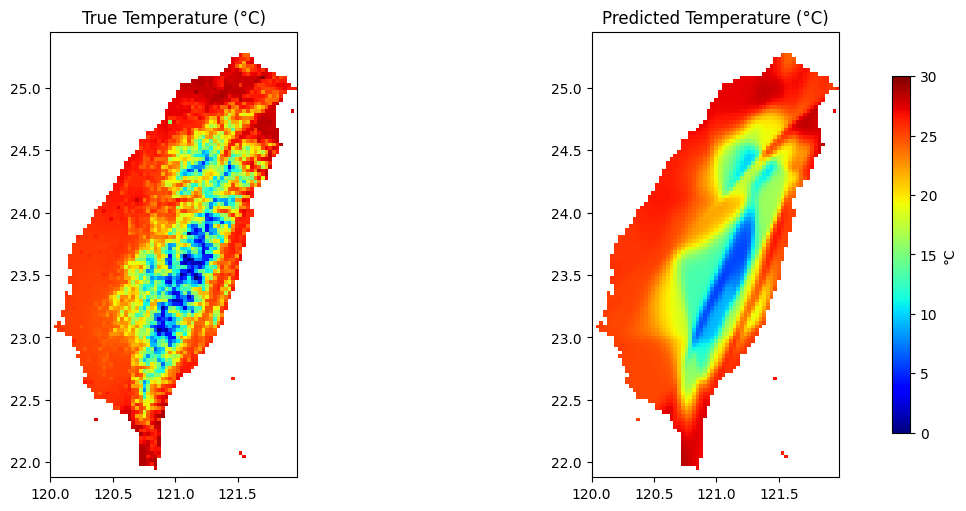

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

im0 = axes[0].imshow(value_grid, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     origin='lower', cmap='jet', vmin=0, vmax=30)
axes[0].set_title("True Temperature (°C)")

im1 = axes[1].imshow(pred_masked, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     origin='lower', cmap='jet', vmin=0, vmax=30)
axes[1].set_title("Predicted Temperature (°C)")

cbar = fig.colorbar(im1, ax=axes, location="right", shrink=0.8)
cbar.set_label("°C")

plt.show()